In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
credit = pd.read_csv('german_credit_data.csv')

In [3]:
credit.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
del credit['Unnamed: 0']

In [5]:
credit.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)

In [7]:
numerical_credit = credit.select_dtypes(exclude='O')

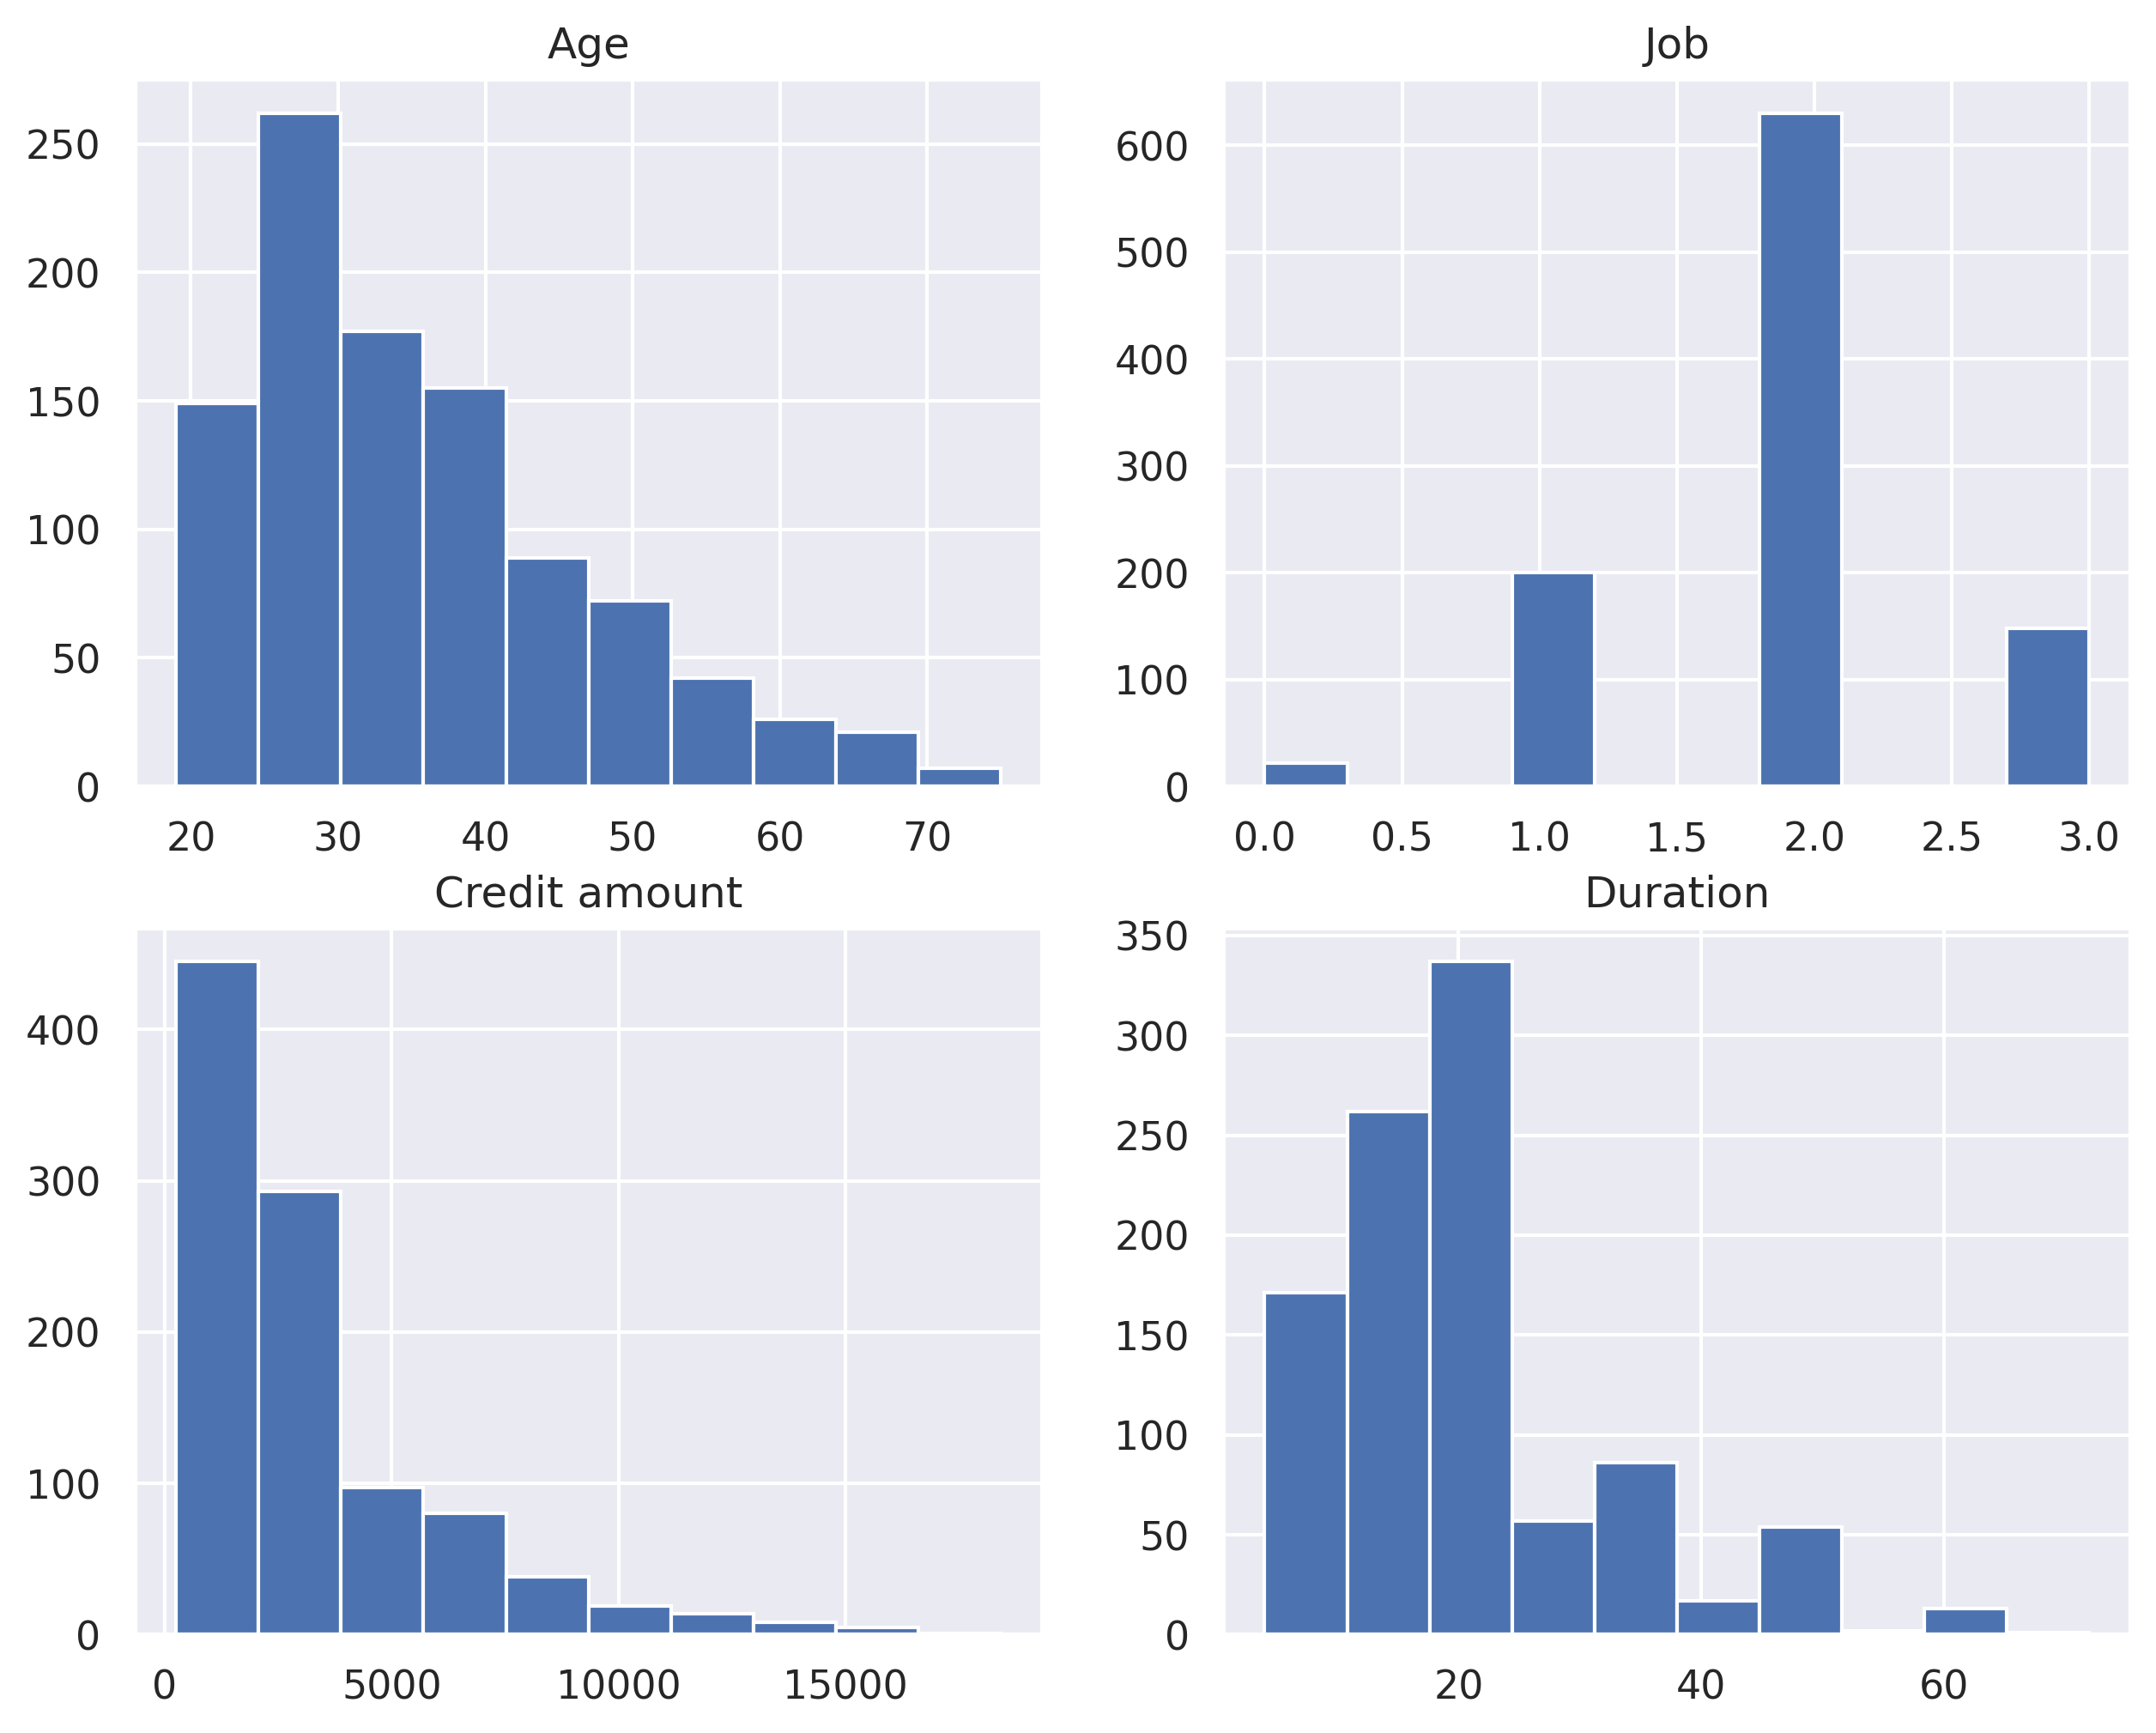

In [8]:
plt.figure(figsize=(10, 8))
k = 0
cols = numerical_credit.columns
for i, j in zip(range(len(cols)), cols):
    k +=1
    plt.subplot(2, 2, k)
    plt.hist(numerical_credit.iloc[:, i])
    plt.title(j)

In [9]:
from sklearn.preprocessing import StandardScaler
import numpy as np

In [10]:
scaler = StandardScaler()
scaled_credit = scaler.fit_transform(numerical_credit)

df_scaled = pd.DataFrame(scaled_credit)
df_scaled['Risk'] = credit['Risk']
df_scaled.columns = ['Age', 'Job', 'Credit amount', 'Duration', 'Risk']

df_scaled['Risk'].value_counts()

good    700
bad     300
Name: Risk, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

df_scaled['Risk'] = df_scaled['Risk'].replace({'good': 1, 'bad': 0})

X = df_scaled.drop('Risk', axis=1)
y = df_scaled.loc[:, ['Risk']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train['Risk']
y_test = y_test['Risk']

In [12]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve


from imblearn.combine import SMOTEENN
smote = SMOTEENN(random_state = 2)

X_train, y_train = smote.fit_resample(X_train, y_train.ravel())

In [25]:
len(y_train)
np.count_nonzero(y_train == 1)

199

# Logistic Regression for PD Estimation

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [ ]:
logit = sm.Logit(y_train, X_train)
logit_fit = logit.fit()
print(logit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.513461
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  456
Model:                          Logit   Df Residuals:                      452
Method:                           MLE   Df Model:                            3
Date:                Wed, 05 Oct 2022   Pseudo R-squ.:                  0.2505
Time:                        09:09:23   Log-Likelihood:                -234.14
converged:                       True   LL-Null:                       -312.38
Covariance Type:            nonrobust   LLR p-value:                 1.055e-33
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age               0.7812      0.124      6.285      0.000       0.538       1.025
Job               0.

In [ ]:
pred_prob = logit_fit.predict(X_test)

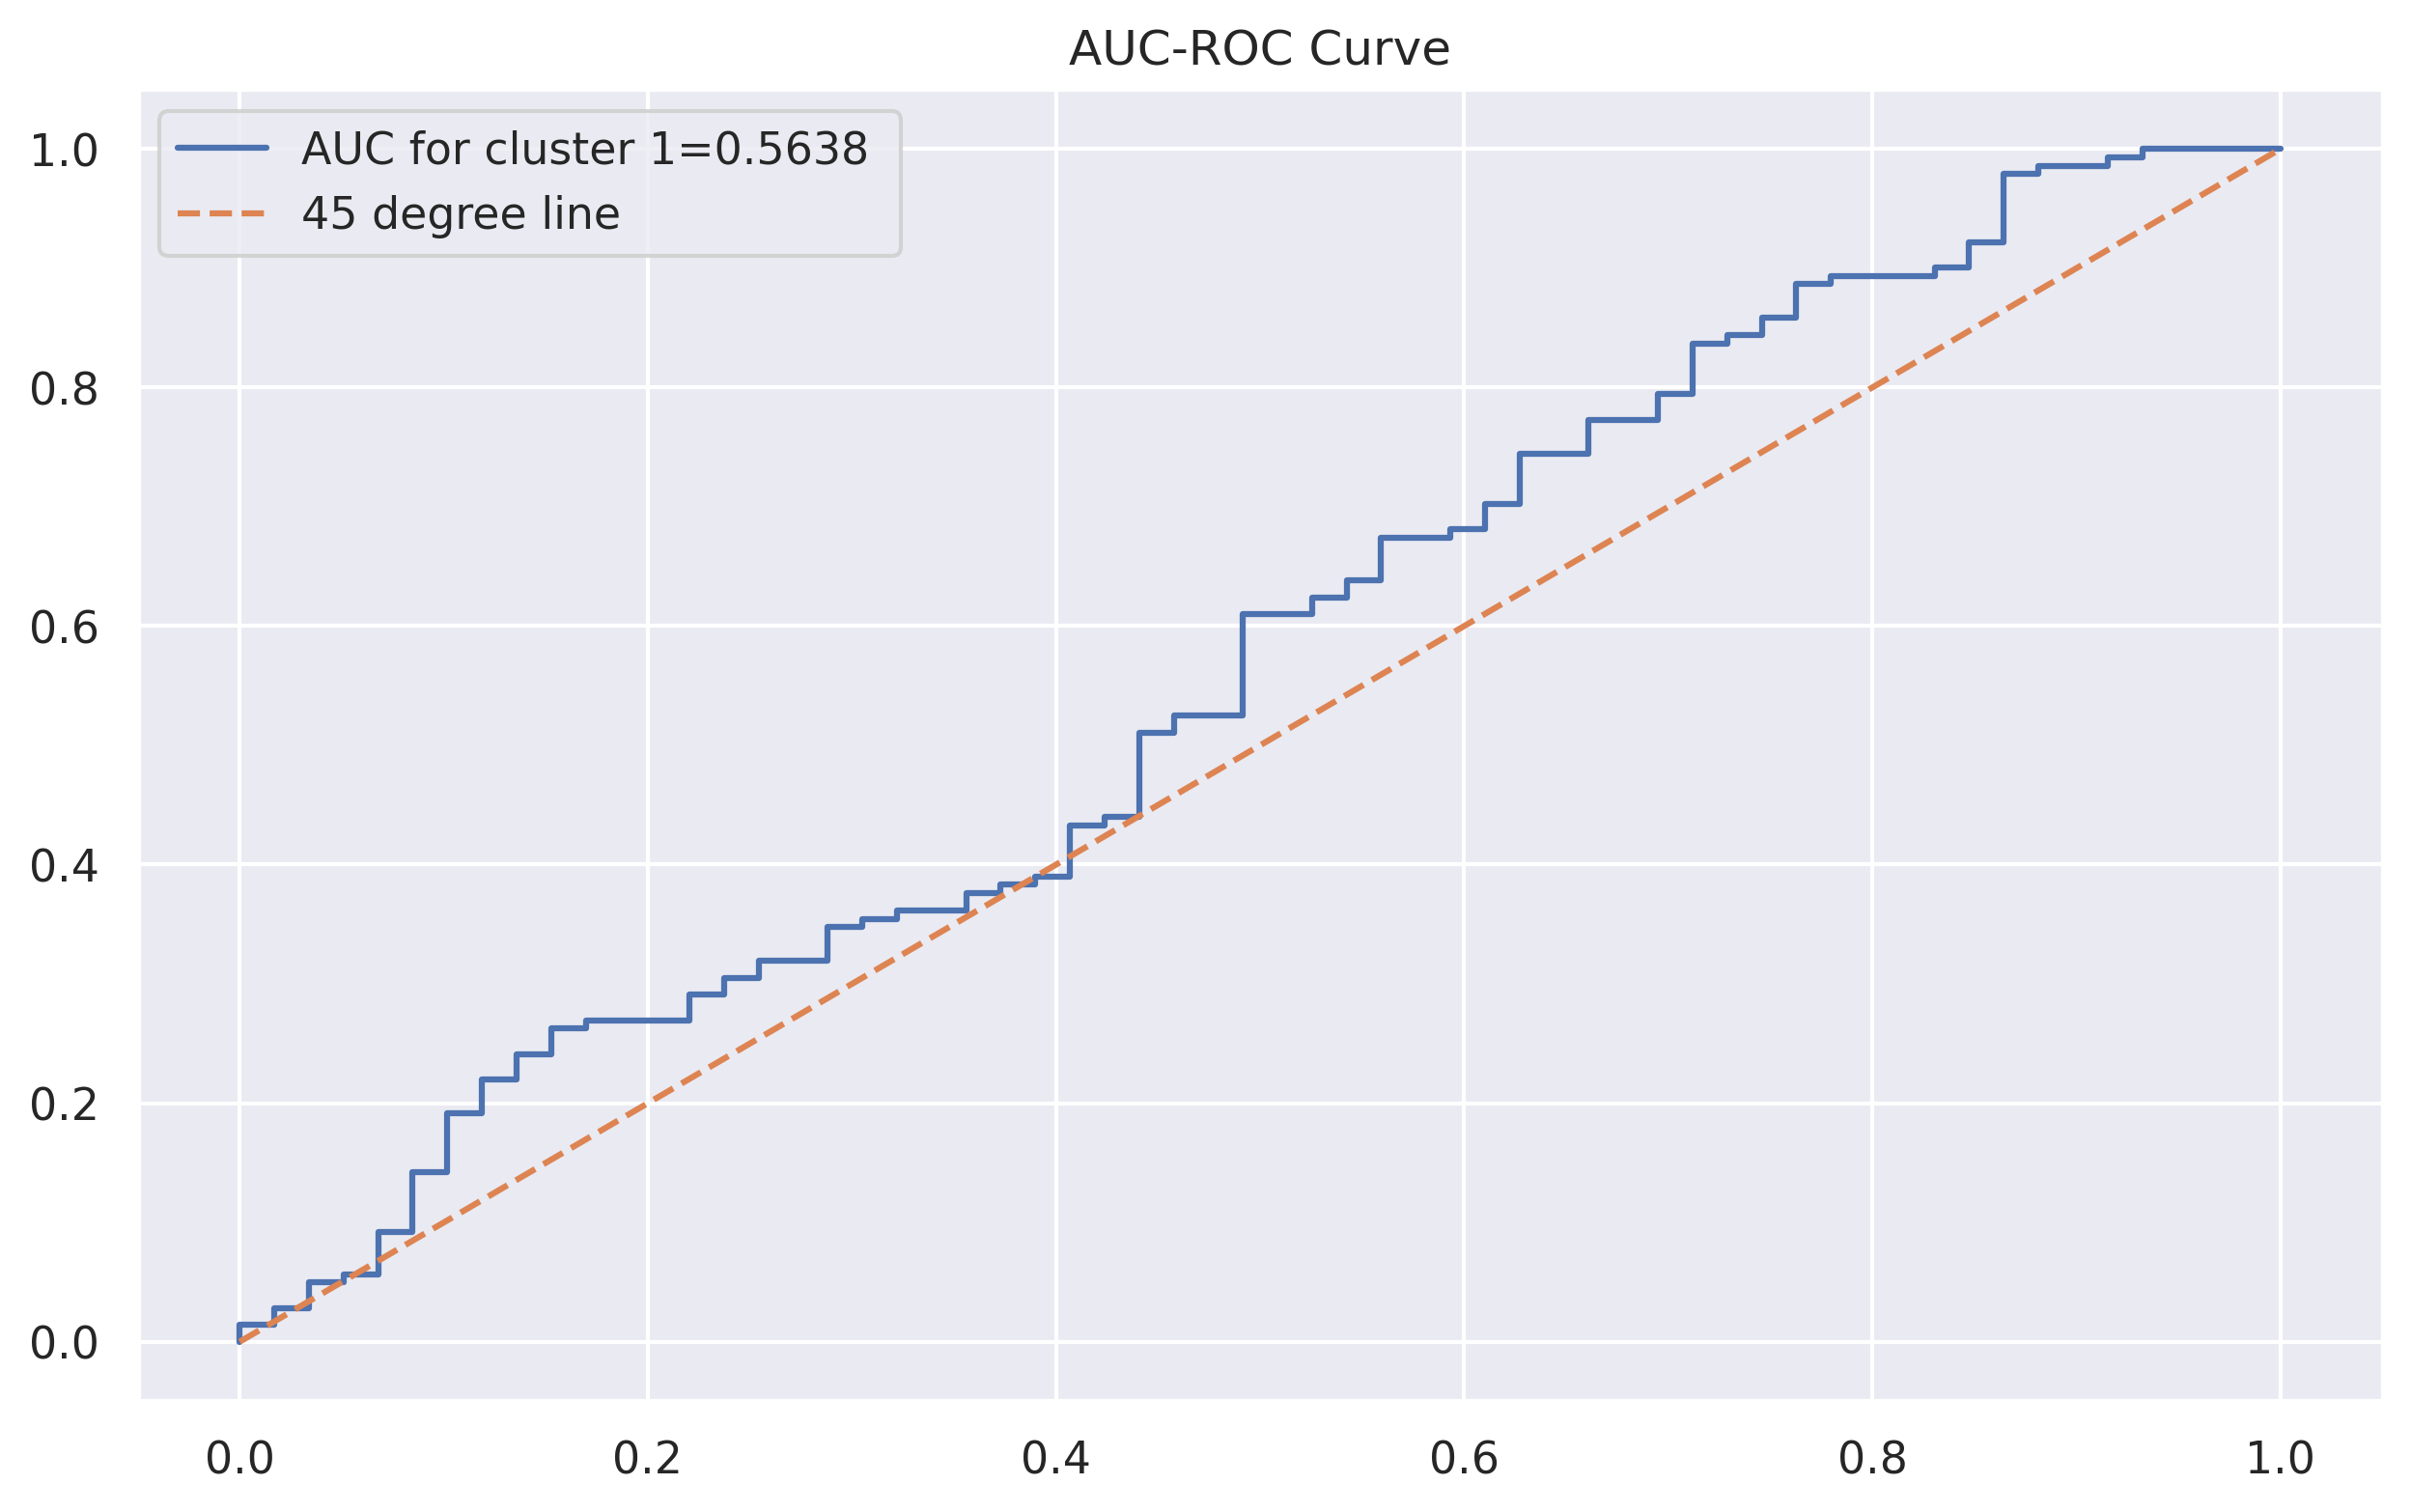

In [ ]:
false_pos, true_pos, _ = roc_curve(y_test.values,  pred_prob)
auc = roc_auc_score(y_test, pred_prob)
plt.plot(false_pos,true_pos, label="AUC for cluster 1={:.4f} "
         .format(auc))
plt.plot([0, 1], [0, 1], linestyle = '--', label='45 degree line')
plt.legend(loc='best')
plt.title('AUC-ROC Curve')
plt.show()

## Bayesian Approach for PD Estimation

In [ ]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 2.1 MB/s 
     |████████████████████████████████| 1.8 MB 53.2 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=d592fb710f0d4c546325d198c4a6a24fe4902ef27f25e4f3b9562c23f55c5157
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc


In [ ]:
import pymc3 as pm
import arviz as az

with pm.Model() as logistic_model:
    beta_age = pm.Normal('coeff_age', mu=0, sd=10)
    beta_job = pm.Normal('coeff_job', mu=0, sd=10)
    beta_credit = pm.Normal('coeff_credit_amount', mu=0, sd=10)
    beta_dur = pm.Normal('coeff_duration', mu=0, sd=10)
    p = pm.Deterministic('p', pm.math.sigmoid(beta_age * 
                              X_train['Age'] + beta_job *
                              X_train['Job'] + beta_credit *
                              X_train['Credit amount'] + beta_dur *
                              X_train['Duration']))
with logistic_model:
    observed = pm.Bernoulli("risk", p, observed=y_train)
    map_estimate = pm.find_MAP()

In [ ]:
param_list = ['coeff_age', 'coeff_job',
              'coeff_credit_amount', 'coeff_duration']
params = {}
for i in param_list:
    params[i] = [np.round(map_estimate[i], 6)] 
    
bayesian_params = pd.DataFrame.from_dict(params)    
print('The result of Bayesian estimation:\n {}'.format(bayesian_params))

The result of Bayesian estimation:
    coeff_age  coeff_job  coeff_credit_amount  coeff_duration
0   0.781083   0.197849            -0.456893       -0.843769


## MCMC method

- 10,000 posterior samples to simulate the posterior distribution for two independent Markov chain

In [ ]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


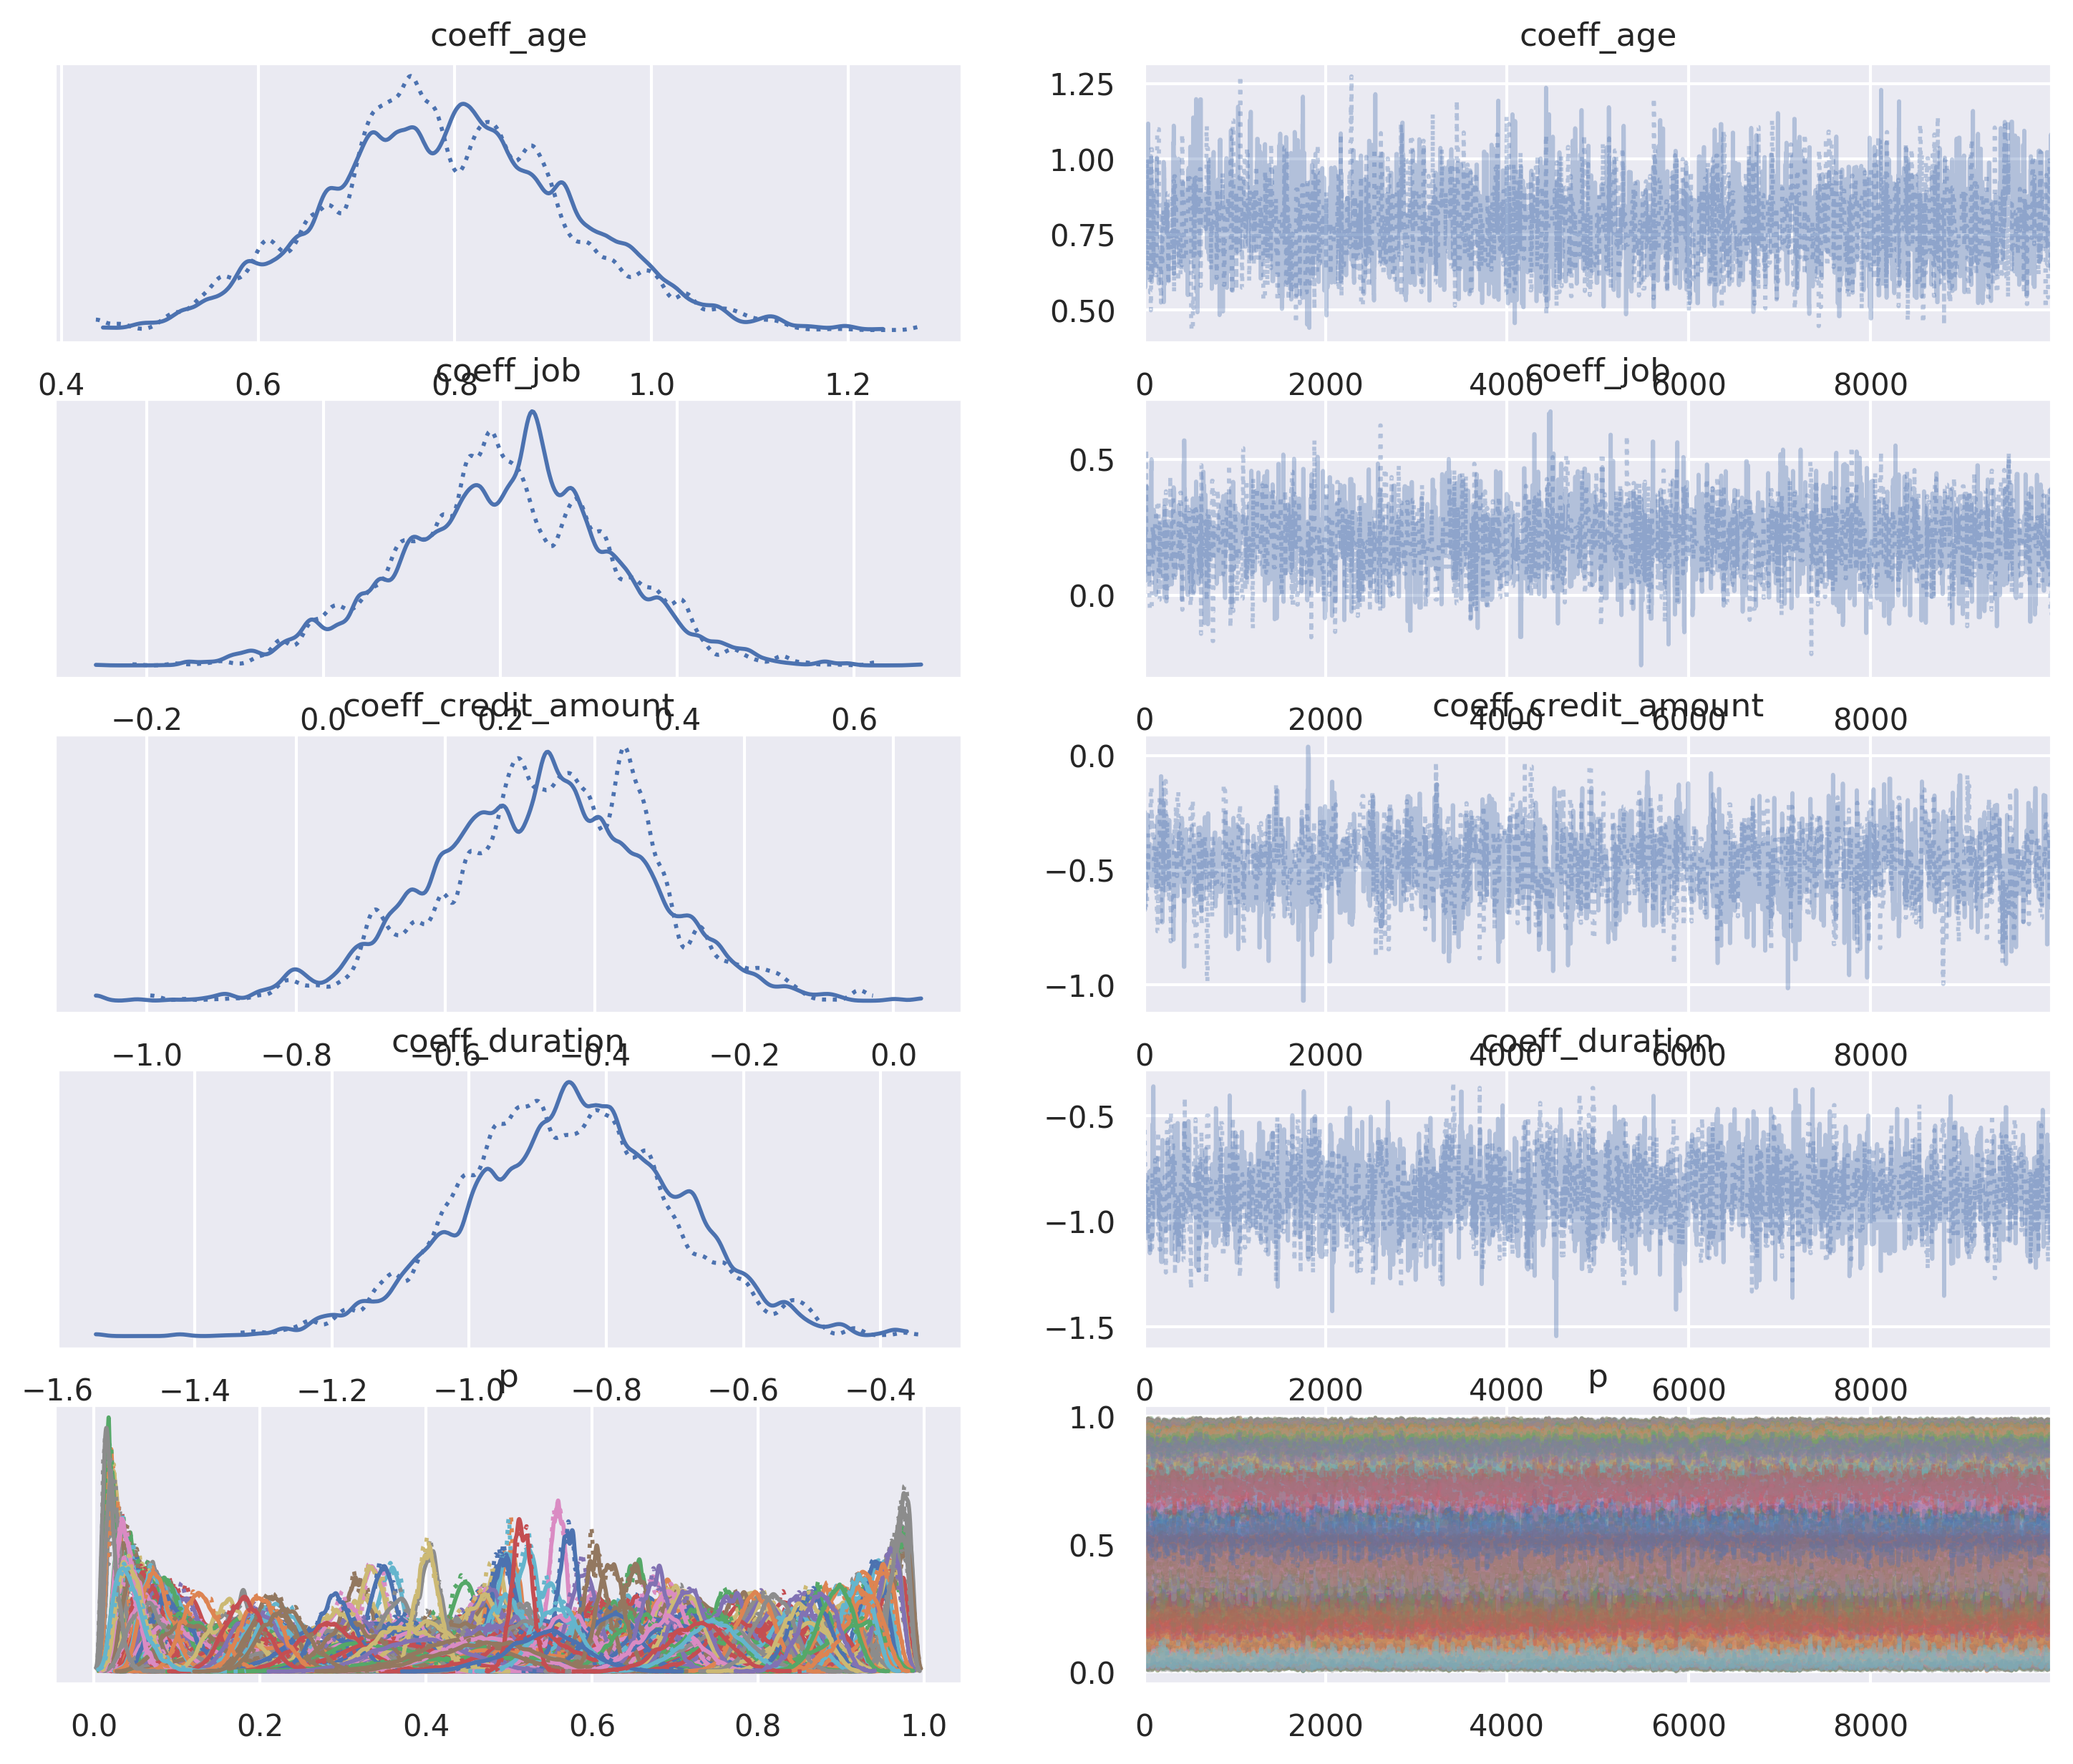

In [ ]:
with logistic_model:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step,progressbar = False)
az.plot_trace(trace)
plt.show()

In [ ]:
with logistic_model:
    display(az.summary(trace, round_to=6)[:4])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coeff_age,0.792226,0.123939,0.545847,1.010120,0.002904,0.002085,1832.524183,2471.467200,1.001059
coeff_job,0.205573,0.116651,-0.023029,0.408547,0.002939,0.002079,1569.101384,1973.771195,1.000901
coeff_credit_amount,-0.469104,0.143090,-0.732447,-0.199553,0.004697,0.003362,932.162755,1267.251841,1.003630
coeff_duration,-0.855783,0.152978,-1.153595,-0.577584,0.004409,0.003118,1201.988003,2138.209825,1.001626


## SVM for PD Estimation

In [26]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import time

In [27]:
param_svc = {'gamma': [1e-6, 1e-2],
             'C':[0.001,.09,1,5,10],
             'kernel':('linear','rbf')}

In [28]:
svc = SVC(class_weight='balanced')
halve_SVC = HalvingRandomSearchCV(svc, param_svc, 
                                  scoring = 'roc_auc', n_jobs=-1)
halve_SVC.fit(X_train, y_train)
print('Best hyperparameters in SVC {} with {}'.
      format(halve_SVC.best_score_, halve_SVC.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 20 is smaller than n_iter=22. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.81714286 0.82984127 0.82380952 0.81714286
 0.81714286 0.84269841 0.85079365]
  category=UserWarning,


Best hyperparameters in SVC 0.8615979672501413 with {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.81714286 0.82984127 0.82380952 0.81714286
 0.81714286 0.84269841 0.85079365 0.84371918 0.83912178 0.86159797]
  category=UserWarning,


In [29]:
y_pred_SVC = halve_SVC.predict(X_test)

print('The ROC AUC score of SVC for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_SVC)))

The ROC AUC score of SVC for first cluster is 0.5586


In [33]:
# Polynomical kernel
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

poly_svm = SVC(kernel="poly", degree=3, coef0=1, C=5)


poly_svm.fit(X_train, y_train)

y_pred_svm_poly = poly_svm.predict(X_test)

print('The ROC AUC score of SVC_poly for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_svm_poly)))

The ROC AUC score of SVC_poly for first cluster is 0.5641


In [34]:
# Gaussian RBF Kernel

rbf_svm = SVC(kernel="rbf", degree=3, coef0=1, C=5)


rbf_svm.fit(X_train, y_train)

y_pred_svm_rbf = rbf_svm.predict(X_test)

print('The ROC AUC score of SVC_poly for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_svm_rbf)))

The ROC AUC score of SVC_poly for first cluster is 0.5896


### Decision Tree for PD Estimation

In [42]:
from sklearn.tree import DecisionTreeClassifier

tree_clf=DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

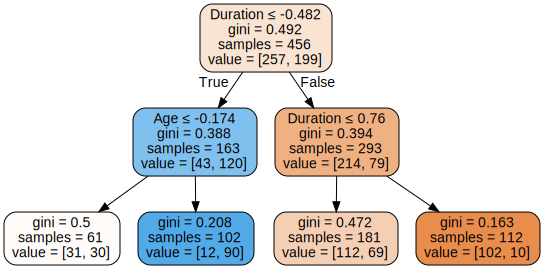

In [51]:
%matplotlib inline

import os, sys
from pathlib import Path
from sklearn.tree import export_graphviz
import graphviz


sys.path.insert(1, os.path.join(sys.path[0], '..'))

results_path = Path('results', 'decision_trees')
if not results_path.exists():
    results_path.mkdir(parents=True)




out_file = results_path / 'credit_tree_1.dot'

export_graphviz(
    tree_clf,
    out_file=out_file.as_posix(),
    feature_names=X_train.columns,
#    class_names=credit
    rounded=True,
    filled=True,
    special_characters=True)

if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

In [52]:
y_pred_dt = tree_clf.predict(X_test)
print('The ROC AUC score of RF for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_dt)))

The ROC AUC score of RF for first cluster is 0.5599


## Random Forest for PD Estimation

In [39]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
param_rfc = {'n_estimators': [100, 300],
    'criterion' :['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3, 4, 5, 6],
    'min_samples_split':[5, 10]}

In [40]:
halve_RF = HalvingRandomSearchCV(rfc, param_rfc,
                                 scoring = 'roc_auc', n_jobs=-1)
halve_RF.fit(X_train, y_train)
print('Best hyperparameters in RF {} with {}'.
      format(halve_RF.best_score_, halve_RF.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.90888889 0.85111111
 0.86333333 0.81888889 0.85555556 0.83888889 0.84555556 0.83222222]
  category=UserWarning,


Best hyperparameters in RF 0.883109649122807 with {'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'gini'}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.90888889 0.85111111
 0.86333333 0.81888889 0.85555556 0.83888889 0.84555556 0.83222222
 0.84990351 0.86288596 0.88310965]
  category=UserWarning,


In [41]:
y_pred_RF = halve_RF.predict(X_test)
print('The ROC AUC score of RF for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_RF)))

The ROC AUC score of RF for first cluster is 0.5606


#### Bagging

In [53]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred_rf_bagging = bag_clf.predict(X_test)
print('The ROC AUC score of RF for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_rf_bagging)))

The ROC AUC score of RF for first cluster is 0.5917


In [54]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_rf_bagging))

0.605


#### Boosting

- AdaBoosting

In [55]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [57]:
y_pred_rf_ada = ada_clf.predict(X_test)
print('The ROC AUC score of RF for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_rf_ada)))

The ROC AUC score of RF for first cluster is 0.5996


- Gradient Boosting

In [58]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [59]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

In [60]:
y_pred_rf_gbrt = gbrt.predict(X_test)
print('The ROC AUC score of RF for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_rf_gbrt)))

The ROC AUC score of RF for first cluster is 0.6983
